
# K Nearest Neighbors 


Predicting if:

  - 'h' house,
  - 'u' duplex, or
  - 't' townhouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Load data
df_melb = pd.read_csv('melb_data_train.csv')
df_melb['Date']

0          7/5/16
1      28/08/2016
2          8/7/17
3      24/06/2017
4      19/11/2016
          ...    
495    29/07/2017
496    16/04/2016
497        8/4/17
498        7/5/16
499      10/12/16
Name: Date, Length: 500, dtype: object

## Transform date attribute to unix

In [2]:
# normalize date accepts the date string as shown in the df_melb 'Date' column
# returns a data in a standarized format
def standardize_date(d):
    d = d.split('/')
    # add '20' to date year
    if len(d[2]) == 2:
        d[2] = '20' + d[2]
    return time.mktime((int(d[2]), int(d[1]), int(d[0]), 0, 0, 0, 0, 1, -1))        

In [3]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 
df_melb['unixtime'] = df_melb['Date']
df_melb = df_melb.drop(columns="Date")

print(f"Min unixtime is {df_melb['unixtime'].min()} and max unixtime is {df_melb['unixtime'].max()}")

The min unixtime is 1454565600.0 and the max unixtime is 1506142800.0


## Fill in missing values (Imputation)

In [4]:
target_col = 'Type'

In [5]:
dict_imputation = dict()
for col in df_melb.columns:
    if col != target_col:
        dict_imputation[col] = df_melb[col].mean()
        # Replace missing values
        df_melb[col] = df_melb[col].fillna(dict_imputation[col])

In [6]:
dict_imputation

{'Rooms': 2.71,
 'Price': 932558.7,
 'Distance': 10.5246,
 'Postcode': 3113.122,
 'Bathroom': 1.44,
 'Car': 1.503006012024048,
 'Landsize': 638.91,
 'BuildingArea': 121.78320000000001,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1485197193.6}

In [7]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0000,1985.000000,1.462597e+09
1,3,h,1241000,13.9,3165,1,1.0,643,121.7832,1970.941748,1.472360e+09
2,2,u,550000,3.0,3067,1,1.0,1521,121.7832,1970.941748,1.499490e+09
3,3,u,691000,8.4,3072,1,1.0,170,121.7832,1970.941748,1.498280e+09
4,2,u,657500,4.6,3122,1,1.0,728,73.0000,1965.000000,1.479535e+09


## Normalize all the attributes to [0,1]

In [8]:
dict_normalize = dict()
for col in df_melb.columns:
    if col != target_col:
        dict_normalize[col] = (df_melb[col].min(), df_melb[col].max())
        # normalize : (x - min) / (max - min)
        df_melb[col] = df_melb[col].apply(lambda x : (x - dict_normalize[col][0]) / (dict_normalize[col][1] - dict_normalize[col][0]))

In [9]:
dict_normalize

{'Rooms': (1, 6),
 'Price': (291000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3002, 3810),
 'Bathroom': (0, 4),
 'Car': (0.0, 4.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 475.0),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1454565600.0, 1506142800.0)}

In [10]:
df_melb

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.2,h,0.022838,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000,0.155720
1,0.4,h,0.200888,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534,0.345013
2,0.2,u,0.054768,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534,0.871013
3,0.4,u,0.084584,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534,0.847561
4,0.2,u,0.077501,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000,0.484121
...,...,...,...,...,...,...,...,...,...,...,...
495,0.2,t,0.088602,0.139485,0.225248,0.25,0.25,0.000000,0.256386,0.720000,0.906191
496,0.2,u,0.032776,0.156652,0.047030,0.25,0.25,0.000000,0.256386,0.647534,0.120542
497,0.4,h,0.126031,0.182403,0.069307,0.25,0.50,0.013527,0.256386,0.647534,0.718573
498,0.4,h,0.227109,0.156652,0.047030,0.25,0.25,0.018213,0.256386,0.647534,0.155720


## Prep test data for classification

In [11]:
df_test = pd.read_csv("melb_data_test.csv")

In [12]:
df_test['Date'] = df_test['Date'].apply( lambda x : standardize_date(x)) 
df_test['unixtime'] = df_test['Date']
df_test = df_test.drop(columns="Date")

print(f"The min unixtime is {df_test['unixtime'].min()} and the max unixtime is {df_test['unixtime'].max()}")

The min unixtime is 1454565600.0 and the max unixtime is 1506142800.0


In [13]:
# Your code here for imputation - must use dictionary from above!
for col in df_test.columns:
    if col != target_col:
        # Replace missing values
        df_test[col] = df_test[col].fillna(dict_imputation[col])
df_test.head()   

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,h,1116000,17.9,3192,1,2.0,610,121.7832,1970.941748,1.498885e+09
1,3,h,2030000,11.2,3186,2,2.0,366,121.7832,1970.941748,1.472360e+09
2,3,h,1480000,10.7,3187,2,2.0,697,143.0000,1925.000000,1.478498e+09
3,3,u,1203500,12.3,3166,2,2.0,311,127.0000,2000.000000,1.495861e+09
4,3,h,540000,14.7,3030,2,2.0,353,135.0000,2011.000000,1.504415e+09


In [14]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    if col != target_col:
        # normalize : (x - min) / (max - min)
        df_test[col] = df_test[col].apply(lambda x : (x - dict_normalize[col][0]) / (dict_normalize[col][1] - dict_normalize[col][0]))
df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.4,h,0.174455,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534,0.859287
1,0.4,h,0.367731,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534,0.345013
2,0.4,h,0.251427,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000,0.464019
3,0.4,u,0.192958,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000,0.800656
4,0.4,h,0.052654,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000,0.966497


## kNN classifier function

In [15]:
def knn_class(df_train, k, target_col, observation, use_weighted_vote ):
    # Function needs to get the distance from each point to the observation row, 
    # take lowest k values (weight if weighted), then count up votes, returning predicted classification.
    observation = observation.drop(labels = target_col)
    target_series = df_train[target_col]
    df_train = df_train.drop(columns = target_col)
    # 1. get array of distances (use la norm)
    distances = df_train.apply(lambda x : np.linalg.norm(observation - x), axis = 1)
    # 2. get k lowest distances and weights
    idxs = np.argpartition(distances, k)[:k]
    # 3. tally up votes
    votes = target_series.iloc[idxs].reset_index(drop = True)
    weights = (1 / distances.iloc[idxs]).reset_index(drop = True) if use_weighted_vote else pd.Series(np.ones(k))
    votes_dict = dict()
    for i in range(len(votes)):
        if votes.iloc[i] not in votes_dict:
            votes_dict[votes.iloc[i]] = weights.iloc[i]
        else:
            votes_dict[votes.iloc[i]] += weights.iloc[i]
    # 4. return classification with highest votes
    return max(votes_dict, key = lambda k : votes_dict[k])

## Test k values using accuracy
For each value of $k$ in $\{1,3,13,25,50,100\}$ 

In [16]:
def get_acc(a, b):
    a = np.array(a)
    b = np.array(b)
    j = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            j += 1
    return j / len(a)

In [17]:
poss_k = [1, 3, 13, 25, 50, 100] # possible k's
acc_k_majority = [] # Accuracy for each value of k using majority voting
acc_k_weighted = [] # Accuracy for each value of k using weighted voting
    
for k in poss_k:
    # add majority voting acc
    predictions = df_test.apply(lambda x : knn_class(df_melb, k, target_col, x, 0), axis = 1)
    acc_k_majority.append(get_acc(df_test[target_col], predictions))
    # add weighted voting acc
    predictions = df_test.apply(lambda x : knn_class(df_melb, k, target_col, x, 1), axis = 1)
    acc_k_weighted.append(get_acc(df_test[target_col], predictions))

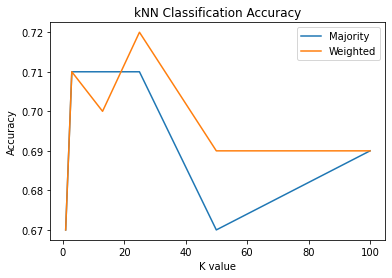

In [18]:
plt.plot(poss_k, acc_k_majority, label = 'Majority')
plt.plot(poss_k, acc_k_weighted, label = 'Weighted')
plt.title('kNN Classification Accuracy')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.legend()

Choose $k = 25$